# Conexão com o Drive (caso necessário)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Base

In [ ]:
!pip install streamlit -q
!pip install keras -q
!pip install pyngrok -q

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import Counter
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
#from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
#from tensorflow.keras.layers import LSTM
#from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GRU
from keras.losses import sparse_categorical_crossentropy
from keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Bossa_Nova/bossa_nova_songs_dataset (1).csv', dtype=str)
diretorio_usado = "/content/drive/MyDrive/Bossa_Nova"
df.head()

,song_name,artist,song_lyrics,song_composition,song_lang
0,Soneto de Fidelidade,Vinicius de Moraes,"De tudo, ao meu amor serei atento antes E co...",Vinícius de Moraes.,pt
1,A Casa,Vinicius de Moraes,Era uma casa Muito engraçada Não tinha teto ...,Sergio Bardotti / Vinícius de Moraes.,pt
2,Onde Anda Você,Vinicius de Moraes,E por falar em saudade Onde anda você Onde a...,Hermano Silva / Vinícius de Moraes.,pt
3,Poema Enjoadinho,Vinicius de Moraes,Filhos... Filhos? Melhor não tê-los! Mas se ...,Vinícius de Moraes.,pt
4,Samba da Bênção,Vinicius de Moraes,É melhor ser alegre que ser triste Alegria é...,Baden Powell / Vinícius de Moraes.,pt


# Exploratoria

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6106 entries, 0 to 6105
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   song_name         6106 non-null   object
 1   artist            6106 non-null   object
 2   song_lyrics       6096 non-null   object
 3   song_composition  6096 non-null   object
 4   song_lang         6106 non-null   object
dtypes: object(5)
memory usage: 238.6+ KB


In [ ]:
df.describe()

,song_name,artist,song_lyrics,song_composition,song_lang
count,6106,6106,6096,6096,6106
unique,5187,133,5943,1556,17
top,Desafinado,Vinicius de Moraes,,Not known,pt
freq,15,321,20,1965,4117


<Axes: title={'center': 'Quantidade de músicas por idioma'}, ylabel='song_lang'>

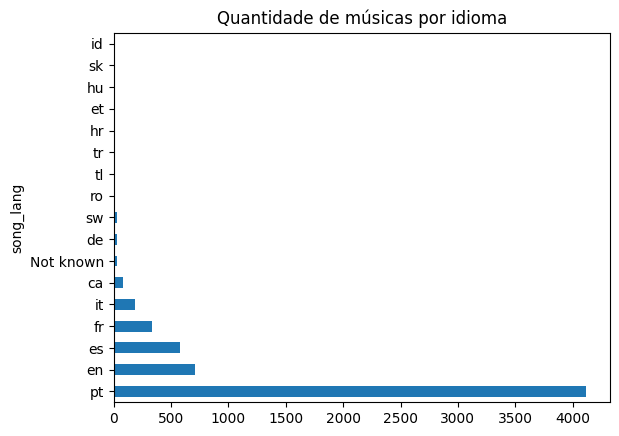

In [ ]:
df['song_lang'].value_counts().plot(kind='barh', title='Quantidade de músicas por idioma')

<Axes: title={'center': 'Top 10 artistas com mais músicas'}, ylabel='artist'>

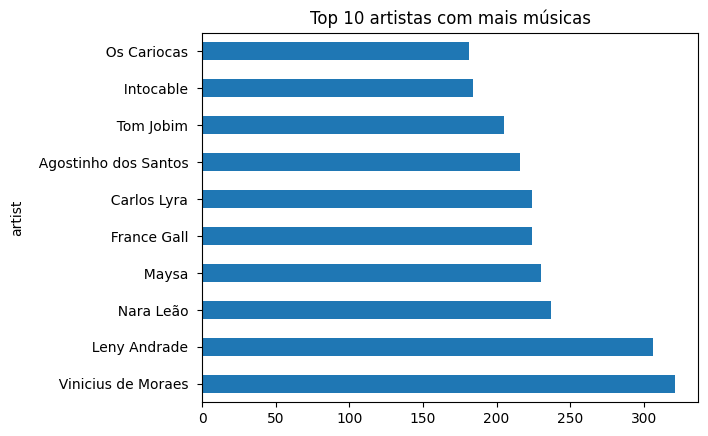

In [ ]:
top_artistas = df['artist'].value_counts().head(10)
top_artistas.plot(kind='barh', title='Top 10 artistas com mais músicas')

<Axes: >

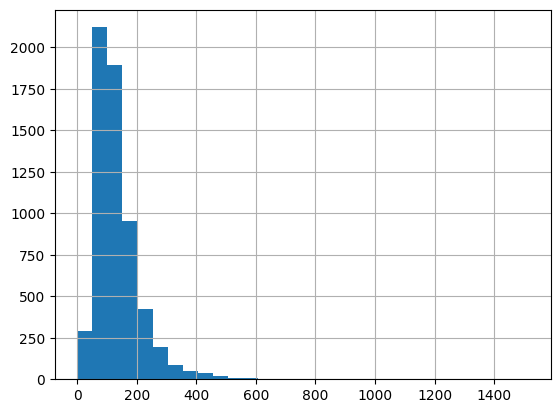

In [ ]:
# número de palavras por letra
df['lyric_length'] = df['song_lyrics'].apply(lambda x: len(str(x).split()))
df['lyric_length'].hist(bins=30)

In [ ]:
df['song_lang'].value_counts()

,count
song_lang,
pt,4117
en,706
es,577
fr,335
it,185
ca,78
Not known,30
de,30
sw,26


In [ ]:
# Texto indesejado presente em algumas letras
texto_indesejado = (
    "essa música foi removida em razão de solicitação do(s) titular(es) da obra. "
    "o letras.mus.br está trabalhando para obter o licenciamento desse conteúdo."
)

# Remover o texto das letras
df['song_lyrics'] = df['song_lyrics'].str.replace(texto_indesejado, '', case=False, regex=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


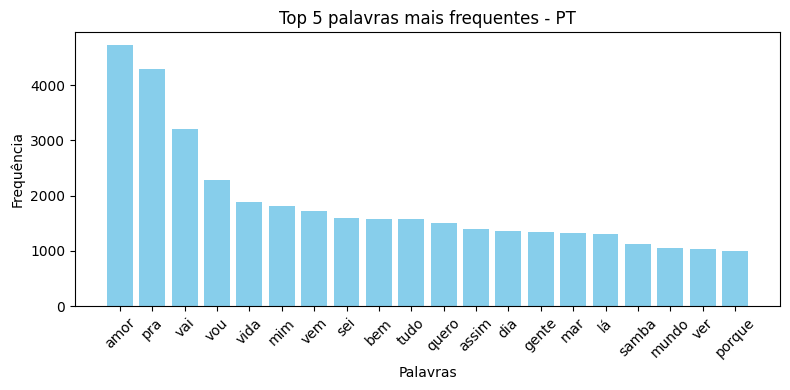

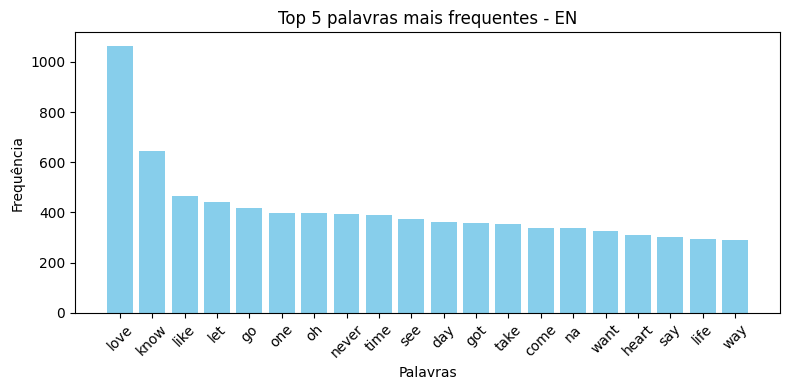

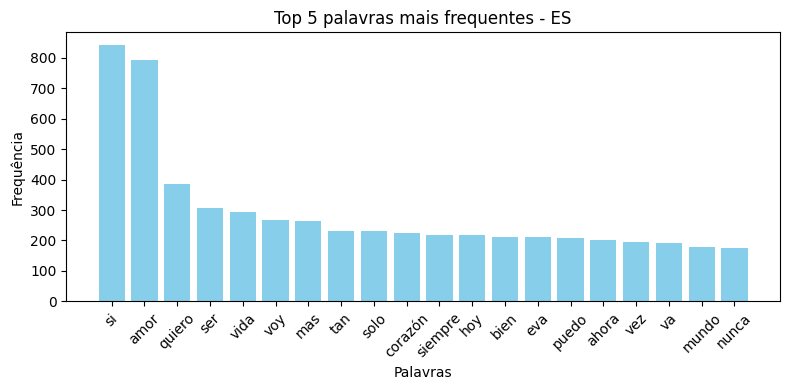

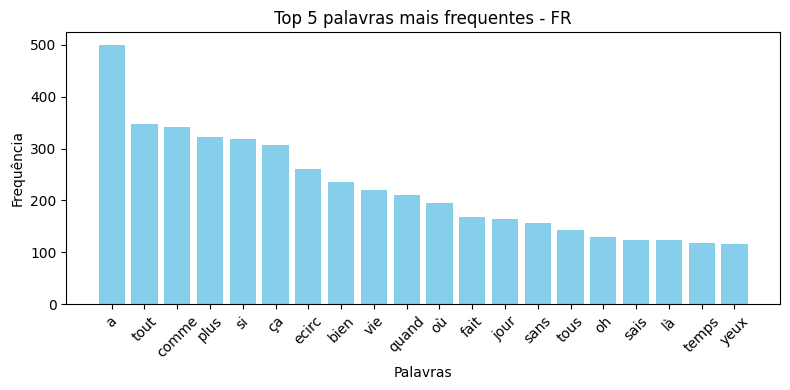

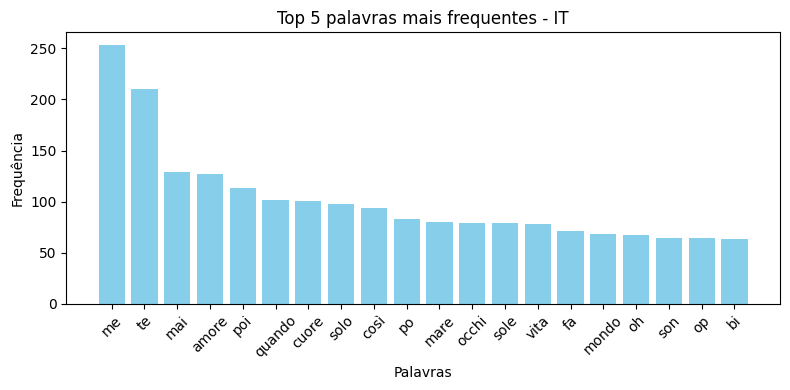

In [ ]:
# Baixar os recursos necessários
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# Mapeamento de códigos para nltk
codigo_para_nltk = {
    'pt': 'portuguese',
    'en': 'english',
    'es': 'spanish',
    'fr': 'french',
    'it': 'italian'
}

todas_palavras = []
contagens_por_idioma = {}

# Loop por idiomas
for codigo in ['pt', 'en', 'es', 'fr', 'it']:
    nltk_lang = codigo_para_nltk[codigo]
    stopwords_idioma = set(stopwords.words(nltk_lang))

    letras = df[df['song_lang'].str.lower() == codigo]['song_lyrics'].dropna().str.lower()
    texto = ' '.join(letras)

    # Tokenizar com NLTK
    tokens = word_tokenize(texto, language=nltk_lang)

    # Filtrar palavras válidas (sem pontuação)
    palavras = [p for p in tokens if re.match(r'^[a-záéíóúàèìòùâêîôûäëïöüçñ]+$', p)]

    # Remover stopwords
    palavras_filtradas = [p for p in palavras if p not in stopwords_idioma]

    todas_palavras.extend(palavras_filtradas)

    contagens_por_idioma[codigo] = Counter(palavras_filtradas).most_common(20)


# Gráficos
for idioma, palavras_freq in contagens_por_idioma.items():
    palavras, frequencias = zip(*palavras_freq)
    plt.figure(figsize=(8, 4))
    plt.bar(palavras, frequencias, color='skyblue')
    plt.title(f'Top 5 palavras mais frequentes - {idioma.upper()}')
    plt.xlabel('Palavras')
    plt.ylabel('Frequência')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Modelo em PT

In [ ]:
# df['song_lyrics'] = df['song_lyrics'].astype(str)
# df_pt = df[df['song_lang'] == 'pt'].copy()
# corpus_letras = ' '.join(df_pt['song_lyrics'])

# vocab = sorted(set(corpus_letras))
# char_to_ind = {char:ind for ind, char in enumerate(vocab)}
# ind_to_char = np.array(vocab)
# encoded_text = np.array([char_to_ind[c] for c in corpus_letras])

# seq_len = 1000
# total_num_seq = len(corpus_letras)//(seq_len+1)
# total_num_seq

# char_dataset = tf.data.Dataset.from_tensor_slices(encoded_text)

# sequences = char_dataset.batch(seq_len+1, drop_remainder=True)

# def create_seq_targets(seq): # Além do horizonte
#     input_txt = seq[:-1]     # Além do horizont
#     target_txt = seq[1:]     # lém do horizonte
#     return input_txt, target_txt

# dataset = sequences.map(create_seq_targets)

# batch_size = 256
# buffer_size = 10000
# dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)

# vocab_size = len(vocab)
# embed_dim = 64
# rnn_neurons = 128

# def sparse_cat_loss(y_true,y_pred):
#     return sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)


# def create_model(vocab_size, embed_dim, rnn_neurons, batch_size):
#     model = Sequential()
#     model.add(Embedding(vocab_size, embed_dim))
#     model.add(GRU(rnn_neurons,return_sequences=True,stateful=False,recurrent_initializer='glorot_uniform'))
#     model.add(Dense(vocab_size))
#     model.compile(optimizer='adam', loss=sparse_cat_loss)
#     return model

# model = create_model(
#   vocab_size = vocab_size,
#   embed_dim=embed_dim,
#   rnn_neurons=rnn_neurons,
#   batch_size=256)

# epochs=1

# model.fit(dataset,epochs=epochs)

# model.save(f'{diretorio_usado}/bn_pt.keras')

# model = create_model(vocab_size, embed_dim, rnn_neurons, batch_size=1)
# model.build(tf.TensorShape([1, None]))
# model.load_weights(f'{diretorio_usado}/bn_pt.keras')

# def generate_text(model, tokenizer, start_seed, gen_size=100, temp=1.0):
#     input_eval = tokenizer.texts_to_sequences([start_seed])[0]
#     input_eval = tf.expand_dims(input_eval, 0)

#     text_generated = []
#     temperature = temp

#     for i in range(gen_size):
#         predictions = model(input_eval)
#         predictions = tf.squeeze(predictions, 0)

#         predictions = predictions / temperature
#         predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

#         input_eval = tf.expand_dims([predicted_id], 0)

#         # Converter índice de volta para palavra
#         for word, index in tokenizer.word_index.items():
#             if index == predicted_id:
#                 predicted_word = word
#                 break
#         else:
#             predicted_word = ''  # caso índice inválido

#         text_generated.append(predicted_word)

#     return start_seed + ' ' + ' '.join(text_generated)

# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(df_pt["song_lyrics"])

# print(generate_text(model, tokenizer, "Amor", gen_size=50, temp=1.0))

# Modelos para os três idiomas

In [ ]:
codigo_para_nltk = {
    'pt': 'portuguese',
    'en': 'english',
    'es': 'spanish'
}

# Baixar os recursos necessários
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

corpus_por_idioma = {}

for lang in ['pt', 'en', 'es']:
    nltk_lang = codigo_para_nltk[lang]
    stopwords_idioma = set(stopwords.words(nltk_lang))

    df_filtrado = df[df["song_lang"] == lang]
    letras = df_filtrado["song_lyrics"].dropna().str.lower()
    corpus = []

    for linha in letras:
        tokens = word_tokenize(linha, language=nltk_lang)
        tokens = [t for t in tokens if t.isalpha() and t not in stopwords_idioma]
        corpus.extend(tokens)

    corpus_por_idioma[lang] = ' '.join(corpus)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Dicionários para armazenar resultados por idioma
char_to_ind_por_idioma = {}
ind_to_char_por_idioma = {}
encoded_text_por_idioma = {}

for lang, corpus_letras in corpus_por_idioma.items():
    vocab = sorted(set(corpus_letras))
    char_to_ind = {char: ind for ind, char in enumerate(vocab)}
    ind_to_char = np.array(vocab)
    encoded_text = np.array([char_to_ind[c] for c in corpus_letras])

    # Armazenar resultados por idioma
    char_to_ind_por_idioma[lang] = char_to_ind
    ind_to_char_por_idioma[lang] = ind_to_char
    encoded_text_por_idioma[lang] = encoded_text

In [ ]:
seq_len = 1000

# Dicionário para armazenar os datasets por idioma
dataset_por_idioma = {}

# Função para criar pares (entrada, alvo)
def create_seq_targets(seq):
    input_txt = seq[:-1]
    target_txt = seq[1:]
    return input_txt, target_txt

# Loop pelos idiomas
for lang, encoded_text in encoded_text_por_idioma.items():
    char_dataset = tf.data.Dataset.from_tensor_slices(encoded_text)
    sequences = char_dataset.batch(seq_len + 1, drop_remainder=True)
    dataset = sequences.map(create_seq_targets)

    dataset_por_idioma[lang] = dataset

In [ ]:
batch_size = 256
buffer_size = 10000

dataset_final_por_idioma = {}

for lang, dataset in dataset_por_idioma.items():
    dataset_final = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)
    dataset_final_por_idioma[lang] = dataset_final


In [ ]:
embed_dim = 64
rnn_neurons = 128
batch_size = 256
tokenizer = Tokenizer()
vocab_size = len(tokenizer.word_index) + 1

# Função de perda
def sparse_cat_loss(y_true, y_pred):
    return sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)

# Função para criar o modelo
def create_model(vocab_size, embed_dim, rnn_neurons, batch_size):
    model = Sequential()
    model.add(Embedding(vocab_size, embed_dim))
    model.add(GRU(rnn_neurons, return_sequences=True, stateful=False, recurrent_initializer='glorot_uniform'))
    model.add(Dense(vocab_size))
    model.compile(optimizer='adam', loss=sparse_cat_loss)
    return model

# Dicionário para armazenar os modelos por idioma
modelos_por_idioma = {}

# Criar modelo por idioma
for lang, vocab in ind_to_char_por_idioma.items():
    vocab_size = len(vocab)
    modelo = create_model(vocab_size, embed_dim, rnn_neurons, batch_size)
    modelos_por_idioma[lang] = modelo

In [ ]:
# Criação dos modelos por idioma
modelos_por_idioma = {}

for lang, vocab_array in ind_to_char_por_idioma.items():
    vocab_size = len(vocab_array)

    model = create_model(
        vocab_size=vocab_size,
        embed_dim=embed_dim,
        rnn_neurons=rnn_neurons,
        batch_size=batch_size
    )

    modelos_por_idioma[lang] = model


In [ ]:
epochs = 5

# Dicionário para armazenar histórico de treinamento
historico_por_idioma = {}

for lang in modelos_por_idioma:
    print(f"\nTreinando modelo para idioma: {lang}")
    model = modelos_por_idioma[lang]
    dataset = dataset_final_por_idioma[lang]

    history = model.fit(dataset, epochs=epochs)
    historico_por_idioma[lang] = history



Treinando modelo para idioma: pt
Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 3.7612
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 3.1003
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 2.8075
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 2.6134
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 2.4689

Treinando modelo para idioma: en
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 3.7359
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step - loss: 3.6665
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step - loss: 3.5814
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - loss: 3.4791
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - loss: 3.3607

Treinando modelo para idioma: es
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 3.6890
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step - loss: 3.6104
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step - loss: 3.5160
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step - loss: 3.4017
Epoch 5/5
1/1

In [ ]:
# Diretório base (ajuste se necessário)
base_path = f"{diretorio_usado}/"

# Dicionário para armazenar modelos carregados com batch_size=1
modelos_inferência_por_idioma = {}

for lang, vocab_array in ind_to_char_por_idioma.items():
    vocab_size = len(vocab_array)
    path_modelo = f"{base_path}bn_{lang}.keras"

    # Salvar o modelo treinado
    modelos_por_idioma[lang].save(path_modelo)

    # Criar novo modelo para inferência com batch_size=1
    modelo_infer = create_model(vocab_size, embed_dim, rnn_neurons, batch_size=1)
    modelo_infer.build(tf.TensorShape([1, None]))

    # Carregar pesos
    modelo_infer.load_weights(path_modelo)

    # Armazenar modelo carregado
    modelos_inferência_por_idioma[lang] = modelo_infer


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
def generate_text(model, tokenizer, start_seed, gen_size=100, temp=1.0):
    input_eval = tokenizer.texts_to_sequences([start_seed])[0]
    input_eval = tf.expand_dims(input_eval, 0)

    text_generated = []
    temperature = temp

    for i in range(gen_size):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)

        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        input_eval = tf.expand_dims([predicted_id], 0)

        # Converter índice de volta para palavra
        for word, index in tokenizer.word_index.items():
            if index == predicted_id:
                predicted_word = word
                break
        else:
            predicted_word = ''  # caso índice inválido

        text_generated.append(predicted_word)

    return start_seed + ' ' + ' '.join(text_generated)


In [ ]:
# Mapeia idioma simples -> nome compatível com modelo
idioma_para_nome_modelo = {
    "pt": "pt",   # exemplo: modelo_bn_pt.keras
    "en": "en",
    "es": "es"
}

tokenizer_por_idioma = {}

for lang in ["pt", "en", "es"]:
    df_filtrado = df[df["song_lang"] == lang].copy()
    df_filtrado["song_lyrics"] = df_filtrado["song_lyrics"].astype(str)

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df_filtrado["song_lyrics"])
    tokenizer_por_idioma[lang] = tokenizer

import json

# Salvar usando nomes compatíveis com os modelos
for lang, tokenizer in tokenizer_por_idioma.items():
    nome_arquivo = idioma_para_nome_modelo[lang]
    data = {
        "word_index": tokenizer.word_index
    }

    with open(f"{diretorio_usado}/tokenizer_{nome_arquivo}.json", "w", encoding="utf-8") as f:
        json.dump(data, f)


In [ ]:
# Português
model_pt = modelos_inferência_por_idioma['pt']
tokenizer_pt = tokenizer_por_idioma['pt']
texto_pt = generate_text(model_pt, tokenizer_pt, "Amor", gen_size=50, temp=1.0)
print("📘 Idioma: PT")
print(texto_pt)

📘 Idioma: PT
Amor  é se por você do mas é que  quando com na e vai mas minha do do vai vida na de de mas e em meu amor os eu você  mim do o vai e em você amor em não que os sem mas tudo tudo meu


In [ ]:
# Inglês
model_en = modelos_inferência_por_idioma['en']
tokenizer_en = tokenizer_por_idioma['en']
texto_en = generate_text(model_en, tokenizer_en, "Love", gen_size=50, temp=1.0)
print("\n📘 Idioma: EN")
print(texto_en)


📘 Idioma: EN
Love and when me a in i'm we know is are this is the your this i know will the have for for for for can when no and and what no me  the we so it it are can no you but it's we that what it's i that


In [ ]:
# Espanhol
model_es = modelos_inferência_por_idioma['es']
tokenizer_es = tokenizer_por_idioma['es']
texto_es = generate_text(model_es, tokenizer_es, "Amor", gen_size=50, temp=1.0)
print("\n📘 Idioma: ES")
print(texto_es)


📘 Idioma: ES
Amor por por la ya su pero me 9474 si de 9474 más las con un es  se sin las quiero lo como no 9474 los los todo los  y  me a un 9474 no sin al es yo lo si a se cuando todo el de de


# Streamlit

## Criar app.py

In [ ]:
# Gerar o código do app.py
diretorio_usado = "/content/drive/MyDrive/Bossa_Nova"
import os

streamlit_app_code = """
import streamlit as st
st.set_page_config(page_title="Gerador de Letras Multilingue", layout="centered")

import os
import json
import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.preprocessing.text import Tokenizer

diretorio_usado = "/content/drive/MyDrive/Bossa_Nova"

@st.cache_resource
def load_all_models_and_tokenizers(model_dir=f"{diretorio_usado}/"):
    modelos = {}
    tokenizers = {}

    def sparse_cat_loss(y_true, y_pred):
        return sparse_categorical_crossentropy(y_true, y_pred)

    for arquivo in os.listdir(model_dir):
        if arquivo.endswith(".keras") and arquivo.startswith("bn_"):
            nome = arquivo.replace("bn_", "").replace(".keras", "")
            try:
                modelos[nome] = load_model(
                    os.path.join(model_dir, arquivo),
                    custom_objects={"sparse_cat_loss": sparse_cat_loss}
                )
            except Exception as e:
                st.warning(f"Erro ao carregar modelo {arquivo}: {e}")

        elif arquivo.endswith(".json") and arquivo.startswith("tokenizer_"):
            nome = arquivo.replace("tokenizer_", "").replace(".json", "")
            try:
                with open(os.path.join(model_dir, arquivo), "r", encoding="utf-8") as f:
                    data = json.load(f)
                    tok = Tokenizer()
                    tok.word_index = data["word_index"]
                    tokenizers[nome] = tok
            except Exception as e:
                st.warning(f"Erro ao carregar tokenizer {arquivo}: {e}")

    return modelos, tokenizers

modelos, tokenizers = load_all_models_and_tokenizers()

if not modelos:
    st.error("❌ Nenhum modelo foi carregado. Verifique se os arquivos .keras estão presentes e corretos.")
    st.stop()

if not tokenizers:
    st.error("❌ Nenhum tokenizer foi carregado. Verifique os arquivos tokenizer_*.json.")
    st.stop()

#st.write("🧠 Modelos carregados:", list(modelos.keys()))
#st.write("🧾 Tokenizers carregados:", list(tokenizers.keys()))

st.title("🎶 Gerador de Letras de Música")

idioma = st.selectbox("🌍 Escolha o modelo/idioma", sorted(modelos.keys()))

start_seed = st.text_input("🔤 Palavra/frase inicial", "amor")
gen_size = st.slider("📏 Tamanho da música", 10, 300, 100, step=10)
temp = st.slider("🌡️ Temperatura", 0.1, 1.0, 0.55, step=0.05)

def generate_text(model, tokenizer, start_seed, gen_size=100, temp=1.0):
    if start_seed not in tokenizer.word_index:
        return None  # Palavra não reconhecida

    input_eval = tokenizer.texts_to_sequences([start_seed])[0]
    input_eval = tf.expand_dims(input_eval, 0)
    text_generated = []

    for _ in range(gen_size):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predictions = predictions / temp
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()
        input_eval = tf.expand_dims([predicted_id], 0)

        predicted_word = next((word for word, index in tokenizer.word_index.items() if index == predicted_id), '')
        text_generated.append(predicted_word)

    return start_seed + ' ' + ' '.join(text_generated)

if st.button("🎤 Gerar letra"):
    with st.spinner("Gerando..."):
        modelo_escolhido = modelos[idioma]

        if idioma not in tokenizers:
            st.error(f"❌ Tokenizer para o modelo '{idioma}' não encontrado.")
        else:
            tokenizer_escolhido = tokenizers[idioma]
            letra = generate_text(modelo_escolhido, tokenizer_escolhido, start_seed, gen_size, temp)

            if letra is None:
                st.warning("⚠️ A palavra inicial não está no vocabulário do modelo. Tente outra.")
            else:
                st.success("✅ Letra gerada com sucesso!")
                st.text_area("🎵 Letra", letra, height=300)

"""

with open(f"{diretorio_usado}/app.py", "w", encoding="utf-8") as f:
    f.write(streamlit_app_code)


## Executar

In [ ]:
!pip install pyngrok -q
!pip install streamlit -q

from pyngrok import ngrok
import time
import subprocess

!ngrok config add-authtoken SEU_AUTH_TOKEN_AQUI

In [ ]:
diretorio_usado = "/content/drive/MyDrive/Bossa_Nova"

# Abrir túnel ngrok na porta do Streamlit
public_url = ngrok.connect("http://localhost:8501")
print("🔗 Acesse o app em:", public_url)

# Rodar o Streamlit
process = subprocess.Popen(["streamlit", "run", f"{diretorio_usado}/app.py"])

## Limpar cache e fecha túneis

In [ ]:
# Fecha todos os túneis abertos nesta sessão
ngrok.kill()
print("✅ Todos os túneis ngrok foram encerrados.")

!pkill streamlit

✅ Todos os túneis ngrok foram encerrados.
